In [1]:
from pandas import Series, DataFrame # data structure for data
from SSUphysicsTools.data_analysis import *
from SSUphysicsTools.data_processing import *
from SSUphysicsTools.Plots import *
from SSUphysicsTools.getting_data import *
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
from scipy.interpolate import interp1d # interpolate data
from sklearn.metrics import root_mean_squared_error # mean squared error

In [2]:
LP_freqs:tuple=(50,100,200,400,800,1600,3200,6400,12800,25600)
HP_freqs:tuple=(50,100,200,400,800,1600,3200,6400,12800,25600)
freqs=LP_freqs+HP_freqs
print(len(freqs))

# 모든 사진 및 table 데이터를 저장할 거냐
save:bool=False
dpi=1000

20


# Orignal data

In [3]:
prignal_plot_names=[f"Low Pass fillter: {freq} Hz" for freq in LP_freqs]
prignal_plot_names+=[f"High Pass fillter: {freq} Hz" for freq in HP_freqs]

'''orignal data를 plot하려면 아래 주석을 해제하시오'''
# plots:Plots=Plots(plot_name=prignal_plot_names)
# if save:
#     plots.orginal_data_plots(is_save=True, dpi=dpi)
# else:
#     plots.orginal_data_plots()

'orignal data를 plot하려면 아래 주석을 해제하시오'

# fitting data

In [4]:
reg=Regression()
all_orginal_data__f=get_all_csv_paths_in_data(flatten=True)()
fitting_data:list=[] # np.array를 사용하면 pandas의 DataFrame 자체도 flat하게 array로 저장되어 버리기 때문에 list로 저장
fitting_functions:list[None|Callable]=[] # fitting function을 저장하는 list
fitted_y_list:list=[] # 원래의 x값을 fitting function에 대입했을 때 y값을 저장하는 list
dir_combined_orginal_data_v:list=[] # orginal data의 voltage를 저장하는 list direrctory combined

for i,orginal_data in enumerate(all_orginal_data__f):
    data:DataFrame=read_csv_Tektronix(orginal_data)['data']
    data_t=data['Time']
    data_v=data['Voltage']

    if i % 2 == 0:
            index = i // 2
    else:
        index = (i - 1) // 2

    fitting_function:Callable=reg.cosine_regression(data_t,data_v,freq=freqs[index])['fitted_func']
    fitting_functions.append(fitting_function)

    # make fitting data
    f_data_t=np.linspace(data_t.iloc[0],data_t.iloc[-1],10000)
    f_data_v=fitting_function(f_data_t)
    fitted_data:DataFrame=DataFrame({'Time':f_data_t,'Voltage':f_data_v})
    fitting_data.append(fitted_data)

    # data collecing for regression evaluation
    dir_combined_orginal_data_v.append(data_v)
    fitted_y=fitting_function(data_t)
    fitted_y_list.append(fitted_y)

unflatten_fitting_data:list=pairwise_to_2d_list(fitting_data) # flatten 되어 있는 걸 다시 2차원 배열로 변환
unflatten_fitting_functions:list[Callable]=pairwise_to_2d_list(fitting_functions)
fitted_y_list=np.array(fitted_y_list) # list로 만들었다가 array로 변한하지 않으면 pandas의 DataFrame 자체도 flat하게 array로 저장되어 버림
dir_combined_orginal_data_v=np.array(dir_combined_orginal_data_v)

print(np.shape(np.array(fitted_y_list)))
print(np.shape(dir_combined_orginal_data_v))

(40, 2499)
(40, 2499)


## fitting result analysis

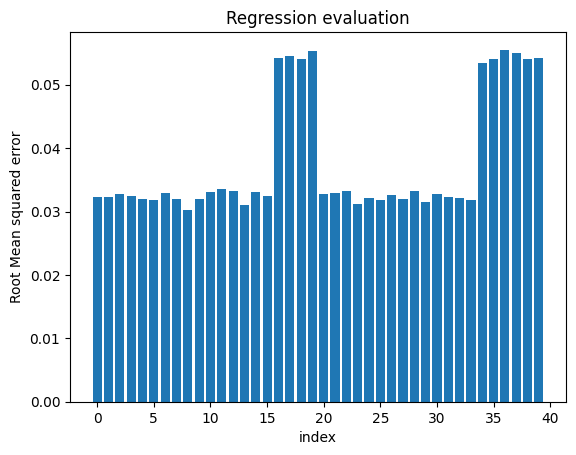

In [5]:
# evaluate regression
RMSE_list:list=[]
for i in range(dir_combined_orginal_data_v.shape[0]):
    RMSE:float|np.ndarray=root_mean_squared_error(dir_combined_orginal_data_v[i],fitted_y_list[i])
    RMSE_list.append(RMSE)

RMSE_series=Series(RMSE_list, name='Root Mean squared error')
plt.bar(RMSE_series.index,RMSE_series)
plt.xlabel('index')
plt.ylabel('Root Mean squared error')
plt.title('Regression evaluation')
if save:
    plt.savefig('fig/Regression_evaluation.png', dpi=dpi)
    RMSE_series.to_csv('tables/RMSE.csv')

plt.show()

# Phase shift

원본 데이터에 너무 큰 offset이 있으면 리사주 plot을 그리기 어려움.

## delate offset

In [6]:
# 만약 original data를 가지고 결과를 보고 싶다면, True, fitting data를 사용해서 결과를 보고 싶다면 False
is_orginal:bool=False

In [7]:
all_orginal_data__f=get_all_csv_paths_in_data(flatten=True)()
all_nonoffset_data:list=[] # np.array를 사용하면 pandas의 DataFrame 자체도 flat하게 array로 저장되어 버리기 때문에 list로 저장

if is_orginal:
    # using orginal data
    for orginal_data in all_orginal_data__f:
        data:DataFrame=read_csv_Tektronix(orginal_data)['data']
        nonoffset_data:DataFrame=Delate_offset(data)()
        all_nonoffset_data.append(nonoffset_data)
else:
    # using fitted data
    for data in fitting_data:
        nonoffset_data:DataFrame=Delate_offset(data)()
        all_nonoffset_data.append(nonoffset_data)

all_nonoffset_data:list=pairwise_to_2d_list(all_nonoffset_data) # flatten 되어 있는 걸 다시 2차원 배열로 변환

## Phase shift plot

In [8]:
ps_results:list=[] # phase shift results
for nonoffset_data in all_nonoffset_data:
    ch1_data1:Series=nonoffset_data[0]['Voltage'] # ch1
    ch2_data1:Series=nonoffset_data[1]['Voltage'] # ch2
    ps_result=Phase_shift(ch1_data1,ch2_data1)()
    ps_results.append(ps_result)
# convert radian to degree
ps_results=np.array([np.rad2deg(ps) for ps in ps_results])

ex1=np.array(freqs[0:10])
ex2=np.array(freqs[10:])

ps1=np.array(ps_results[0:10])
offset_ps1=ps1-90 # 90도를 빼줌
ps2=np.array(ps_results[10:])

# 이론값
R=503
C=0.47*10**-6
T_ps_1=np.rad2deg(np.arctan(-1/(2*np.pi*ex1*R*C)))
T_ps_2=np.rad2deg(np.arctan(1/(2*np.pi*ex2*R*C)))
# min_T_ps_2=np.min(T_ps_2)
# offset_T_ps_2=T_ps_2+abs(min_T_ps_2)

# error rate
## LP
LP_df_phase_shift=DataFrame({'Frequency(Hz)':ex1,'Phase shift (degree)':offset_ps1,'Theoretical phase shift (degree)':T_ps_1,'Error rate(%)':get_error_rate(T_ps_1,offset_ps1)})

## HP
HP_df_phase_shift=DataFrame({'Frequency(Hz)':ex2,'Phase shift (degree)':ps2,'Theoretical phase shift (degree)':T_ps_2,'Error rate(%)':get_error_rate(T_ps_2,ps2)})

# save table
if save:
    LP_df_phase_shift.to_csv('tables/LP_phase.csv',index=False)
    HP_df_phase_shift.to_csv('tables/HP_phase.csv',index=False)

## table

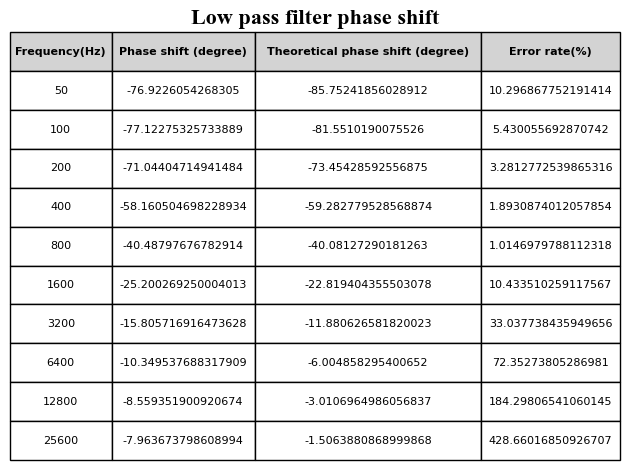

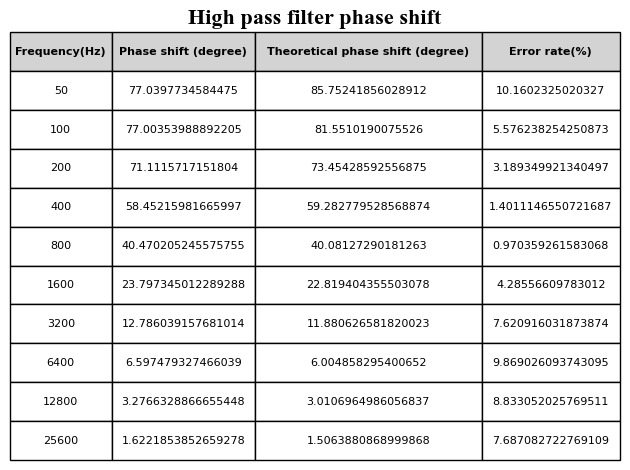

In [9]:
plot_table(LP_df_phase_shift,title='Low pass filter phase shift')
plot_table(HP_df_phase_shift,title='High pass filter phase shift')

## plot

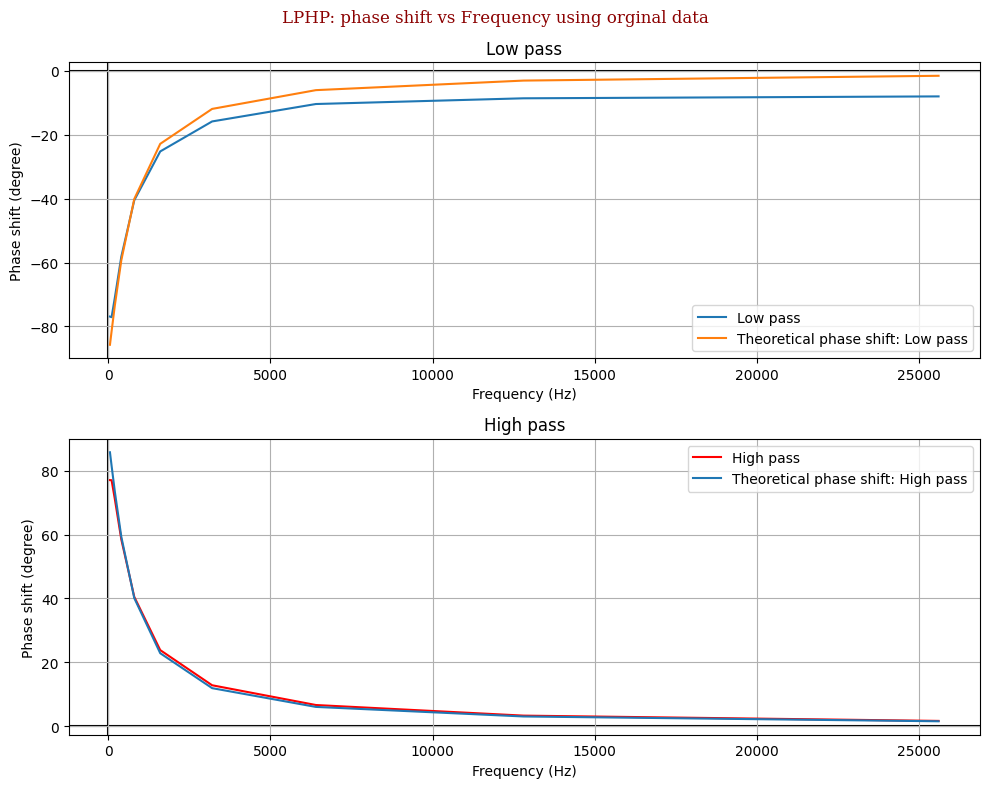

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(ex1,offset_ps1, label='Low pass')
ax1.plot(ex1,T_ps_1, label='Theoretical phase shift: Low pass')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Phase shift (degree)')
ax1.set_title('Low pass')
ax1.grid()
ax1.axvline(x=0, color='black', zorder=-1)
ax1.axhline(y=0, color='black', zorder=-1)
ax1.legend()

ax2.plot(ex2,ps2,color='red',label='High pass')
ax2.plot(ex2,T_ps_2, label='Theoretical phase shift: High pass')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase shift (degree)')
ax2.set_title('High pass')
ax2.axvline(x=0, color='black', zorder=-1)
ax2.axhline(y=0, color='black', zorder=-1)
ax2.grid()
ax2.legend()

font = {'family': 'serif', 'color': 'darkred', 'fontweight': 'bold', 'fontsize': 16}
fig.suptitle(f'LPHP: phase shift vs Frequency using orginal data', fontdict=font)

plt.tight_layout()
if save:
    plt.savefig('fig/LPHP_phase_shift.png',dpi=dpi)
plt.show()
plt.close(fig)# plot을 명시적으로 닫음.

### error rate

In [11]:
# error rate
ex1_error_rates=get_error_rate(T_ps_1,offset_ps1)
ex2_error_rates=get_error_rate(T_ps_2,ps2)
print(ex1_error_rates)
print(ex2_error_rates)

[ 10.29686775   5.43005569   3.28127725   1.8930874    1.01469798
  10.43351026  33.03773844  72.35273805 184.29806541 428.66016851]
[10.1602325   5.57623825  3.18934992  1.40111466  0.97035926  4.2855661
  7.62091603  9.86902609  8.83305203  7.68708272]


# 진폭 변화

이론적인 진폭 변화(주파수 비율)
$$
X_c := -{1 \over 2 \pi f C}
\\
LP: \ V_{ratio}=|{X_C \over  \sqrt{(R^2+X_C^2)}}|
\\
HP: \ V_{ratio}={R \over  \sqrt{(R^2+X_C^2)}}
$$

In [12]:
X_C:np.ndarray=-1/(2*np.pi*np.array(freqs)*C)
V_ratio__1:np.ndarray=np.abs(X_C/(R**2+X_C**2)**0.5)
V_ratio__2:np.ndarray=R/(R**2+X_C**2)**0.5
V_ratio__1=V_ratio__1[0:10] # LP
V_ratio__2=V_ratio__2[10:] # HP

실험값과 비교

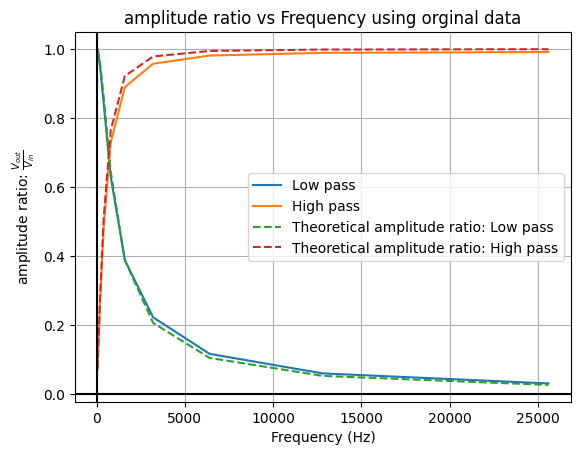

In [13]:
amplitudes:list=[] # amplitude results
for nonoffset_data in all_nonoffset_data:
    ch1_data1:Series=nonoffset_data[0]['Voltage'] # ch1
    ch2_data1:Series=nonoffset_data[1]['Voltage'] # ch2
    amp_ch1=ch1_data1.max()-ch1_data1.min()
    amp_ch2=ch2_data1.max()-ch2_data1.min()
    amp_ratio=amp_ch2/amp_ch1
    amplitudes.append(amp_ratio)

am1=np.array(amplitudes[0:10])
am2=np.array(amplitudes[10:])

# plot
plt.plot(ex1,am1, label='Low pass')
plt.plot(ex2,am2,label='High pass')
plt.plot(ex1,V_ratio__1, label='Theoretical amplitude ratio: Low pass', linestyle='--')
plt.plot(ex2,V_ratio__2, label='Theoretical amplitude ratio: High pass', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'amplitude ratio: $\frac{V_{out}}{V_{in}}$')
plt.legend()
plt.title('amplitude ratio vs Frequency using orginal data')
plt.grid()
plt.axvline(x=0, color='black')
plt.axhline(y=0, color='black')
if save:
    plt.savefig('fig/amplitude_ratio.png', dpi=1000)
plt.show()
plt.close()

### Error rate

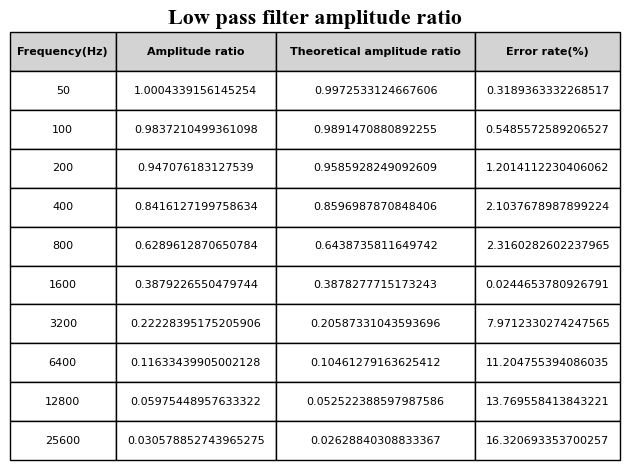

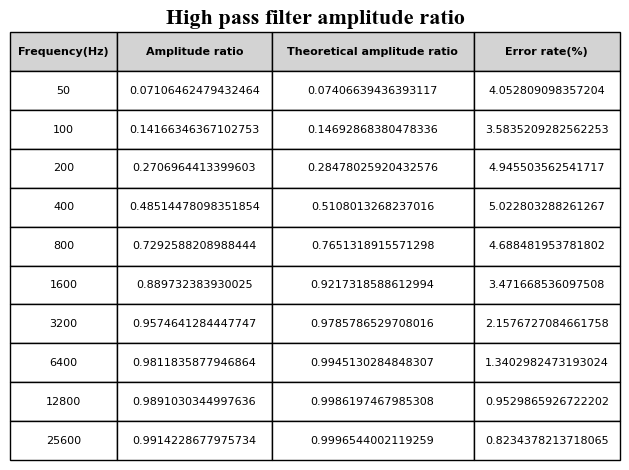

In [14]:
# error rate
am1_error_rates=get_error_rate(V_ratio__1,am1)
am2_error_rates=get_error_rate(V_ratio__2,am2)
am1_df=DataFrame({'Frequency(Hz)':ex1,'Amplitude ratio':am1,'Theoretical amplitude ratio':V_ratio__1,'Error rate(%)':am1_error_rates})
am2_df=DataFrame({'Frequency(Hz)':ex2,'Amplitude ratio':am2,'Theoretical amplitude ratio':V_ratio__2,'Error rate(%)':am2_error_rates})

if save:
    am1_df.to_csv('tables/LP_amplitude_ratio.csv',index=False)
    am2_df.to_csv('tables/HP_amplitude_ratio.csv',index=False)

# plot table
plot_table(am1_df,title='Low pass filter amplitude ratio')
plot_table(am2_df,title='High pass filter amplitude ratio')

# bode plot

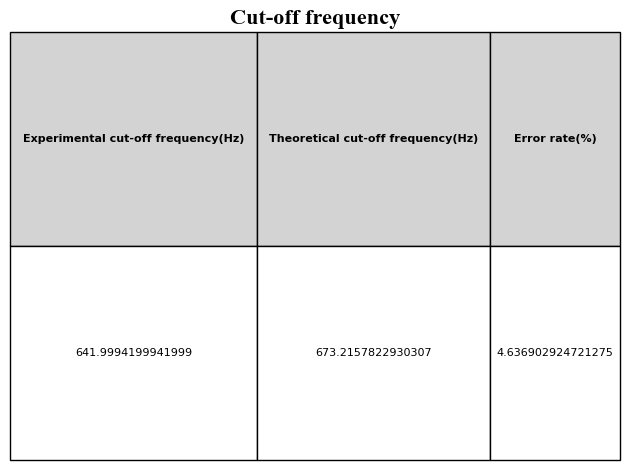

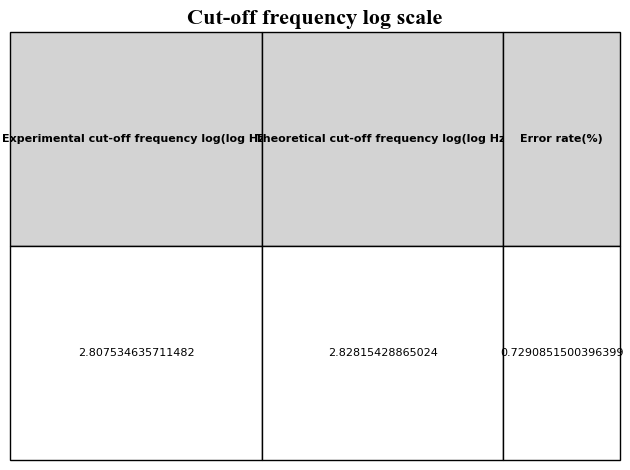

In [15]:
# magnitude
bode_mag=20*np.log10(amplitudes)
bode_mag_low=bode_mag[0:10]
bode_mag_high=bode_mag[10:]
# frequency
bode_freqs=np.log10(freqs)
bode_freqs_low=bode_freqs[0:10]
bode_freqs_high=bode_freqs[10:]

# cut-off frequency
## experimental cut-off frequency
### low pass
f_1=interp1d(ex1,am1, kind='cubic')
freqs_new=np.linspace(ex1[0],ex1[-1],100000)
am1_new=f_1(freqs_new)
closest_index = np.argmin(np.abs(am1_new - 1/np.sqrt(2)))
E__f_c = freqs_new[closest_index]
## theoretical cut-off frequency
T__f_c=1/(2*np.pi*R*C)
# print('Theoretical cut-off frequency: ',T__f_c)
# print('Error rate: ',get_error_rate(T__f_c,E__f_c), '%')

log_E__f_c=np.log10(E__f_c)
log_T__f_c=np.log10(T__f_c)

cut_f_df=DataFrame({'Experimental cut-off frequency(Hz)':E__f_c,'Theoretical cut-off frequency(Hz)':T__f_c,'Error rate(%)':get_error_rate(T__f_c,E__f_c)},index=[0])
plot_table(cut_f_df,title='Cut-off frequency')

# log scale plot
log_cut_f_df=DataFrame({'Experimental cut-off frequency log(log Hz)':log_E__f_c,'Theoretical cut-off frequency log(log Hz)':log_T__f_c,'Error rate(%)':get_error_rate(log_T__f_c,log_E__f_c)},index=[0])
plot_table(log_cut_f_df,title='Cut-off frequency log scale')

if save:
    cut_f_df.to_csv('tables/cut-off_frequency.csv',index=False)
    log_cut_f_df.to_csv('tables/cut-off_frequency_log.csv',index=False)

## Low pass filter

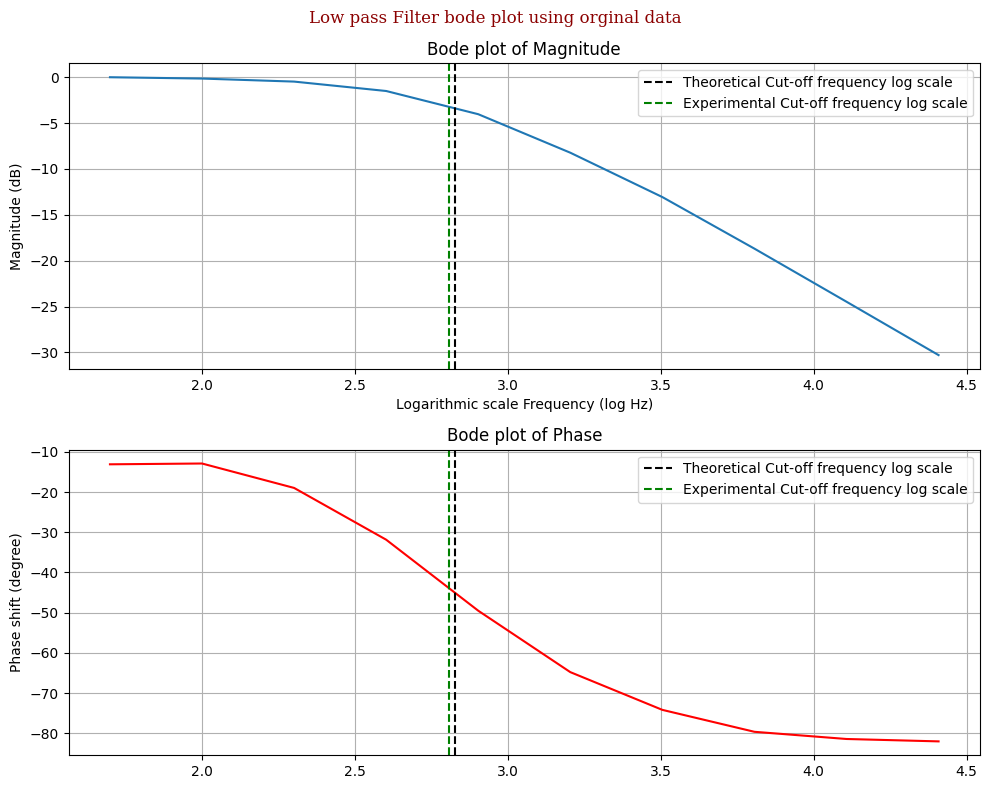

In [16]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(bode_freqs_low,bode_mag_low)
ax1.grid()
ax1.set_title('Bode plot of Magnitude')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_xlabel('Logarithmic scale Frequency (log Hz)')
ax1.axvline(x=log_T__f_c, color='black',linestyle='--',label='Theoretical Cut-off frequency log scale')
ax1.axvline(x=log_E__f_c, color='green',linestyle='--',label='Experimental Cut-off frequency log scale')
ax1.legend()

ax2.plot(bode_freqs_low,-ps1,color='red')
ax2.grid()
ax2.set_title('Bode plot of Phase')
ax2.set_ylabel('Phase shift (degree)')
ax2.axvline(x=log_T__f_c, color='black',linestyle='--',label='Theoretical Cut-off frequency log scale')
ax2.axvline(x=log_E__f_c, color='green',linestyle='--',label='Experimental Cut-off frequency log scale')
ax2.legend()

font = {'family': 'serif', 'color': 'darkred', 'fontweight': 'bold', 'fontsize': 16}
fig.suptitle(f'Low pass Filter bode plot using orginal data', fontdict=font)
plt.tight_layout()
if save:
    plt.savefig('fig/LP_bode.png',dpi=dpi)
plt.show()
plt.close()

## High pass filter

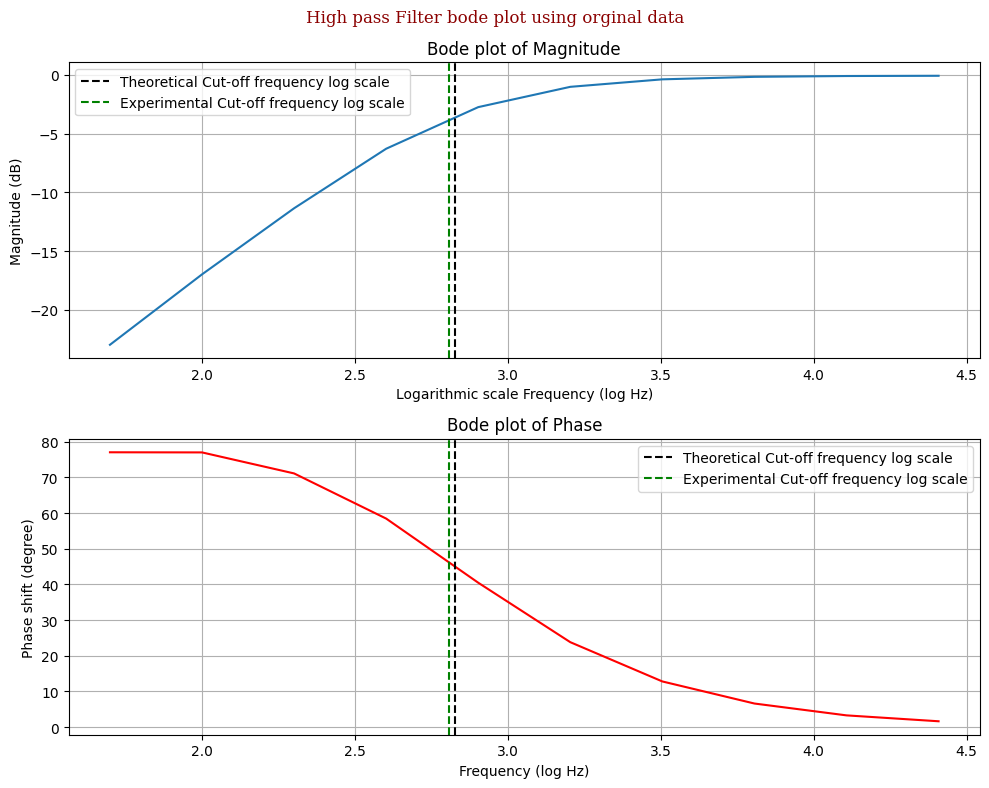

In [17]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(bode_freqs_high,bode_mag_high)
ax1.grid()
ax1.set_title('Bode plot of Magnitude')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_xlabel('Logarithmic scale Frequency (log Hz)')
ax1.axvline(x=log_T__f_c, color='black',linestyle='--',label='Theoretical Cut-off frequency log scale')
ax1.axvline(x=log_E__f_c, color='green',linestyle='--',label='Experimental Cut-off frequency log scale')
ax1.legend()

ax2.plot(bode_freqs_high,ps2,color='red')
ax2.grid()
ax2.set_title('Bode plot of Phase')
ax2.set_ylabel('Phase shift (degree)')
ax2.set_xlabel('Frequency (log Hz)')
ax2.axvline(x=log_T__f_c, color='black',linestyle='--',label='Theoretical Cut-off frequency log scale')
ax2.axvline(x=log_E__f_c, color='green',linestyle='--',label='Experimental Cut-off frequency log scale')
ax2.legend()

font = {'family': 'serif', 'color': 'darkred', 'fontweight': 'bold', 'fontsize': 16}
fig.suptitle(f'High pass Filter bode plot using orginal data', fontdict=font)
plt.tight_layout()
if save:
    plt.savefig('fig/HP_bode.png',dpi=dpi)
plt.show()
plt.close()